In [12]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, Flatten, Dropout, MaxPooling3D

AUTOTUNE = tf.data.experimental.AUTOTUNE

print("Tensorflow Version: ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow Version:  2.1.0
Num GPUs Available:  1


In [2]:
path = pathlib.Path('export/data/dataset.npz')
with np.load(path, mmap_mode="r") as data:
    train_examples = data['dataset'][:310]
    train_labels = data['labels'][:310]
    val_examples = data['dataset'][311:347]
    val_labels = data['labels'][311:347]
    test_examples = data['dataset'][347:386]
    test_labels = data['labels'][347:386]

train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_examples, val_labels))

In [3]:
BATCH_SIZE = 4
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [7]:
model = Sequential([
    Conv3D(16, (1, 4, 3), activation='relu', input_shape=(15, 240, 320, 3)),
    MaxPooling3D(),
    Conv3D(32, (1, 4, 3), activation='relu'),
    MaxPooling3D(),
    Conv3D(64, (1, 4, 3), activation='relu'),
    MaxPooling3D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 15, 237, 318, 16)  592       
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 7, 118, 159, 16)   0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 7, 115, 157, 32)   6176      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 3, 57, 78, 32)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 3, 54, 76, 64)     24640     
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 1, 27, 38, 64)     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65664)            

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(train_dataset, epochs=100, callbacks=[callback], validation_data=val_dataset)
model.evaluate(test_dataset)

Train for 78 steps, validate for 9 steps
Epoch 1/100
78/78 [==============================] - 19s 245ms/step - loss: 1.6697 - accuracy: 0.5484 - val_loss: 0.6873 - val_accuracy: 0.6389
Epoch 2/100
78/78 [==============================] - 18s 237ms/step - loss: 0.6712 - accuracy: 0.6419 - val_loss: 0.6398 - val_accuracy: 0.6944
Epoch 3/100
78/78 [==============================] - 18s 234ms/step - loss: 0.6279 - accuracy: 0.6968 - val_loss: 0.6800 - val_accuracy: 0.5833
Epoch 4/100
78/78 [==============================] - 18s 232ms/step - loss: 0.5782 - accuracy: 0.7129 - val_loss: 0.5726 - val_accuracy: 0.7778
Epoch 5/100
78/78 [==============================] - 18s 232ms/step - loss: 0.5517 - accuracy: 0.7484 - val_loss: 0.5258 - val_accuracy: 0.7778
Epoch 6/100
78/78 [==============================] - 18s 229ms/step - loss: 0.4913 - accuracy: 0.7935 - val_loss: 0.5294 - val_accuracy: 0.8056
Epoch 7/100
78/78 [==============================] - 18s 232ms/step - loss: 0.4706 - accuracy: 

[0.644799891859293, 0.82051283]

10/10 - 1s - loss: 0.6448 - accuracy: 0.8205


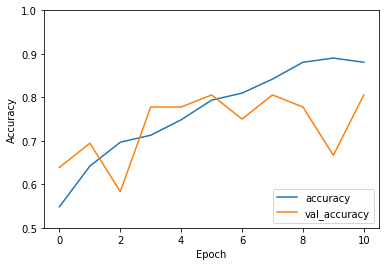

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

In [15]:
export_path = pathlib.Path("export/model.h5")
print("Exporting trained model to {}".format(export_path.absolute()))

model.save(export_path)

Exporting trained model to d:\Dev\Projects\SpeechActionClassifier\export\model.h5
